In [1]:
#==========================#
# Import relevant packages #
#==========================#


import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erfinv
from iminuit import Minuit
from scipy.stats import chi2
from scipy.stats import binom
%matplotlib inline
from scipy.stats import poisson
from iminuit import Minuit

### Functions

In [2]:
#=======================================================#
# Create a function which calculates the time of flight #
#=======================================================#


def calcToF(L, c, m, p):
    return ( (L/c)*np.sqrt(1+((m*c)/p)**2) )

In [3]:
#==============================================================#
# Create a function which calculates the z score given p value #
#==============================================================#
def calcZ(p_val):
    n_sigma = np.sqrt(2) * erfinv(1-p_val)
    return n_sigma

### Classes

In [4]:
#============================#
# Create the Gaussian class  #
#============================#


class Gaussian(object):

    #————————————————————————————————————————————————————————#
    # Class constructor | initialize an attribute mass array #
    #————————————————————————————————————————————————————————#

    def __init__(self, mean, sigma):
   
        self.mean = mean
        self.sigma = sigma
        self.loBound_distribution = self.mean - 10.*self.sigma # 10 sigma from the mean, so the range covers the whole distribution
        self.hiBound_distribution = self.mean + 10.*self.sigma # 10 sigma from the mean, so the range covers the whole distribution

        #initialize an mass list used to store mass values
        self.mass = []
    
    
    #——————————————————————————————————#
    # Evaluation method (un-normalize) #
    #——————————————————————————————————#

    def evaluate(self, x):
        return (1/(self.sigma*np.sqrt(2.*np.pi))) * np.exp( -(x-self.mean)**2/(2.*self.sigma**2) )
    

    #———————————————————————————————————————————————————————#
    # An addition function for evt generating given the no. #
    #———————————————————————————————————————————————————————#

    def evt_gen(self, n_evts):
        for i in range(n_evts):
            i = self.next()


    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrateBelow(self, midBound):
        integral_result, integral_err = quad(self.evaluate, self.loBound_distribution, midBound)
        return integral_result
    
    def integrateAbove(self, midBound):
        integral_result, integral_err = quad(self.evaluate, midBound, self.hiBound_distribution)
        return integral_result


    #————————————————————————————————————————————————————————————————————#
    # Function that generate a single random vars using np.random.normal #
    # method generated var is returned and appended to the mass list     #
    #————————————————————————————————————————————————————————————————————#

    def next(self):
        x = np.random.normal(self.mean, self.sigma, size=1).item()
        self.mass.append(x)
        return x

In [5]:
#===========================================================================================================================#
# Create the ROC class used to calculates (alpha_i, beta_i) pairs of ToF performance for distinguishing b/w pions and kaons #
#===========================================================================================================================#


class ROC(object):


    #——————————————————————————#
    # Define class constructor #
    #——————————————————————————#

    def __init__(self, p, sigma, kaon_mass, pion_mass, scint_counters_dist, c, n_evts=10000, n_step=100):
        self.ToF_kaon = calcToF(scint_counters_dist, c, kaon_mass, p)
        self.ToF_pion = calcToF(scint_counters_dist, c, pion_mass, p)

        self.pdf_kaon = Gaussian(self.ToF_kaon, sigma)
        self.pdf_pion = Gaussian(self.ToF_pion, sigma)

        self.alpha_vals = []
        self.beta_vals = []

        # Generate evts for both pdf using the function within the Gaussian class
        self.pdf_kaon.evt_gen(n_evts)
        self.pdf_pion.evt_gen(n_evts)

        # now define an array with tCut values at each performance point
        self.p_points = np.linspace(self.ToF_pion, self.ToF_kaon, n_step, endpoint=True)


    #——————————————————————————————————————————————————————————————————————#
    # Function used to compute the alpha and beta value for the hypotheses #
    # kaon as "null hypo" and pion as "alternative hypo". Which, alpha     #
    # is the kaon area below tCut and beta is pion area above tCut         #
    #——————————————————————————————————————————————————————————————————————#

    def calc_alpha_beta(self, tCut):
        alpha = self.pdf_kaon.integrateBelow(tCut)
        beta = self.pdf_pion.integrateAbove(tCut)
        return (alpha, beta)
    

    #————————————————————————————————————————————————————————#
    # Compute all alpha beta vals for all performance points #
    #————————————————————————————————————————————————————————#
    
    def calc_ROC(self):
        for i in self.p_points:
            alpha, beta = self.calc_alpha_beta(i)
            self.alpha_vals.append(alpha)
            self.beta_vals.append(beta)
        return self.alpha_vals, self.beta_vals
        

In [6]:
#==============================================================#
# A linear class similar to the previous CP, but flat/no slope #
#==============================================================#


class Flat(object):
    
    #————————————————————————————————————————————————————————#
    # Class constructor | initialize an attribute mass array #
    #————————————————————————————————————————————————————————#

    def __init__(self, intercept, slope, mean, sigma, loBound, highBound):

        # background para    
        self.loBound = loBound
        self.highBound = highBound
        self.intercept = intercept
        self.slope = slope
        self.sigma = sigma
        self.mean = mean
        self.loBound_distribution = self.mean - 10.*self.sigma # 10 sigma from the mean, so the range covers the whole distribution
        self.hiBound_distribution = self.mean + 10.*self.sigma # 10 sigma from the mean, so the range covers the whole distribution


        #initialize an mass list used to store mass values
        self.mass = []
        

    #——————————————————————————————————————————————————————#
    # Find maximum value of the distribution within limits #
    #——————————————————————————————————————————————————————#

    def find_max(self, func, low_limit, high_limit, grid=10000):
        x = np.linspace(low_limit, high_limit, num=grid, endpoint=True)
        y = func(x)
        return y.max()
    

    #——————————————————————————————————#
    # Evaluation method (un-normalize) #
    #——————————————————————————————————#

    def evaluate (self, t):
        return self.intercept + self.slope * t
    

    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrateBelow(self, midBound):
        integral_result, integral_err = quad(self.evaluate, self.loBound_distribution, midBound)
        return integral_result
    
    def integrateAbove(self, midBound):
        integral_result, integral_err = quad(self.evaluate, midBound, self.hiBound_distribution)
        return integral_result


    #———————————————————————————————————————————————————————————————#
    # Function that generate a single random vars using box method, #
    # generated var is returned and appended to the mass list       #
    #———————————————————————————————————————————————————————————————#
    

    def next(self):

        doLoop = True
        while doLoop==True:
            # start with uniform random number in [bounds]
            x = np.random.uniform(self.loBound, self.highBound)
            y1 = self.evaluate(x)
            y2 = np.random.uniform(0, self.find_max(self.evaluate, self.loBound, self.highBound))
            if (y2<y1):
                filtered_x = x
                self.mass.append(filtered_x)
                return filtered_x

In [7]:
#===============================================================#
# A signalWithBackground class like last cp, for pdf generating #
#===============================================================#

class SignalWithBackground(object):

    #————————————————————————————————————————————————————————#
    # Class constructor | initialize an attribute mass array #
    #————————————————————————————————————————————————————————#

    def __init__(self, intercept, slope, sigma, mean, loBound, highBound, signalFraction):
        
        self.loBound = loBound
        self.highBound = highBound
        self.signalFraction = signalFraction

        # initialize lists for holding randomly generated vals
        self.mass_bkg = []
        self.mass_sig = []
        self.mass = []

        # initialize pdf objects
        self.signal = Gaussian(mean, sigma)
        self.bkg = Flat(intercept, slope, mean, sigma, loBound, highBound)

        self.loBound_distribution = mean - 10.*sigma # 10 sigma from the mean, so the range covers the whole distribution
        self.hiBound_distribution = mean + 10.*sigma # 10 sigma from the mean, so the range covers the whole distribution



    #——————————————————————————————————#
    # Evaluation method (un-normalize) #
    #——————————————————————————————————#

    def evaluate(self, x):
        return self.signalFraction*self.signal.evaluate(x) + self.bkg.evaluate(x)
    

    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate, loBound, highBound)
        return integral_result
    
    
    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrateBelow(self, midBound):
        integral_result, integral_err = quad(self.evaluate, self.loBound_distribution, midBound)
        return integral_result
    
    def integrateAbove(self, midBound):
        integral_result, integral_err = quad(self.evaluate, midBound, self.hiBound_distribution)
        return integral_result



    #————————————————————————————————————————————————————————————————————#
    # Function that generate a single random vars using np.random.normal #
    # method generated var is returned and appended to the mass list     #
    #————————————————————————————————————————————————————————————————————#

    def next(self):
        
        q = np.random.uniform()
        if (q<self.signalFraction):
            # if here, we will draw x from signal distribution
            filtered_x = self.signal.next()
            self.mass_sig.append(filtered_x)
        else:
            # if here, we will draw x from background distribution
            filtered_x = self.bkg.next()
            self.mass_bkg.append(filtered_x)

        self.mass.append(filtered_x)
        return filtered_x    

In [8]:
#=============================================================================#
# Create a class containing the chi-square equivalent of the log likelyhood   #
# statistic for optimization                                                  #
#=============================================================================#

class ChiSquaredLogLike(object):
    
    #———————————————————#
    # Class constructor #
    #———————————————————#

    def __init__(self, pdf, data, bins):
        self.pdf = pdf
        self.n_obs_measurements = data
        self.mass_bins = bins

        # limit the outputs of observed measurements to positive
        if (self.n_obs_measurements<=0).any():
            self.n_obs_measurements[self.n_obs_measurements<=0] = 1e-10


    #—————————————————————————————————————————————#
    # Function that gets the normalization factor #
    #—————————————————————————————————————————————#

    def normFactor(self):
        low_norm_lim = self.pdf.loBound
        high_norm_lim = self.pdf.highBound

        return self.pdf.integrate(low_norm_lim, high_norm_lim)
    

    #——————————————————————————————————————————————————————————————————————#
    # Function evaluating chiSq equiv. of log likelyhood (null hypothesis) #
    #——————————————————————————————————————————————————————————————————————#

    def evalNull(self, intercept):
        #Set new parameters if passed parameters aren't nan
        if not (np.isnan(intercept).any()):
            self.pdf.bkg.intercept = intercept

        # calc normalization factor
        normFactor = self.normFactor()
        n_expected_measurements = self.pdf.evaluate(self.mass_bins)/normFactor

        # limit the outputs of expected measurements to only pos
        if (n_expected_measurements<=0).any():
            n_expected_measurements[n_expected_measurements<=0] = 1e-10

        withinSum = n_expected_measurements - self.n_obs_measurements + \
            self.n_obs_measurements*np.log(self.n_obs_measurements/n_expected_measurements)
        
        return 2*withinSum.sum()
    
    #—————————————————————————————————————————————————————————————————————#
    # Function evaluating chiSq equiv. of log likelyhood (alt hypothesis) #
    #—————————————————————————————————————————————————————————————————————#

    def evalAlt(self, intercept, signalFraction):
        #Set new parameters if passed parameters aren't nan
        if not (np.isnan(intercept).any()):
            self.pdf.bkg.intercept = intercept
            self.pdf.signalFraction = signalFraction

        # calc normalization factor
        normFactor = self.normFactor()
        n_expected_measurements = self.pdf.evaluate(self.mass_bins)/normFactor

        # limit the outputs of expected measurements to only pos
        if (n_expected_measurements<=0).any():
            n_expected_measurements[n_expected_measurements<=0] = 1e-10

        withinSum = n_expected_measurements - self.n_obs_measurements + \
            self.n_obs_measurements*np.log(self.n_obs_measurements/n_expected_measurements)
        
        return 2*withinSum.sum()

In [9]:
#=====================#
# A class for fitting #
#=====================#

class Fit(object):

    #———————————————————#
    # Class constructor #
    #———————————————————#

    def __init__(self, data, loBound, hiBound, bins):
        self.data = data
        self.loBound = loBound
        self.hiBound = hiBound
        self.bins = bins
        
        self.null_chiSq = []
        self.alt_chiSq = []
        self.chiSq_difference = []

    #———————————————————————————————————————————————————————#
    # Function for null hypothesis and calculates the chiSq #
    #———————————————————————————————————————————————————————#

    def nullFit(self):
        pdf = SignalWithBackground(intercept=1., sigma=1e-10, mean=0., slope=0., loBound=self.loBound, highBound=self.hiBound, signalFraction=0)
        nullStat = ChiSquaredLogLike(pdf, self.data, self.bins)
        minuit_null = Minuit(nullStat.evalNull, intercept=1.)
        result = minuit_null.migrad()
        self.null_chiSq.append(result.fval)


    #——————————————————————————————————————————————————————#
    # Function for alt hypothesis and calculates the chiSq #
    #——————————————————————————————————————————————————————#

    def altFit(self, mean):
        pdf = SignalWithBackground(intercept=1., slope=0., sigma=12e-3, mean=mean,loBound=self.loBound,\
                                   highBound=self.hiBound, signalFraction=1.)
        altStat = ChiSquaredLogLike(pdf, self.data, self.bins)
        minuit_alt = Minuit(altStat.evalAlt, intercept=1., signalFraction=1.)
        result = minuit_alt.migrad()
        self.alt_chiSq.append(result.fval)

    #——————————————————————————————————————————————————————#
    # Function for alt hypothesis and calculates the chiSq #
    #——————————————————————————————————————————————————————#
    def calc_chiSq_diff(self):
        for i in range(len(self.alt_chiSq)):
            chiSq_diff_val = self.null_chiSq[0] - self.alt_chiSq[i]
            self.chiSq_difference.append(chiSq_diff_val)
        return self.chiSq_difference
    
    
    def scan_mass(self):
        self.nullFit()

        # now, loop over all means while fitting 
        for i in self.bins:
            self.altFit(mean=i)
            
        self.calc_chiSq_diff()

### Code Execution (Problem Set CP5)

**Problem 1**

In [10]:
def run_Q1():

    # Define the relevant parameters
    claimedFaultyRate = 0.05
    sampleSize = 100
    trueFaultyRate = 0.15
    tCut = 9                # max no. of faulty monitors willing to have
    t = np.arange(0, 100, 1) # for sample of 100 monitors
    
    # Question (a) of Problem 1
    # first define binom distribution for the claimed faulty
    claimedFaultyDistribution = binom(sampleSize, claimedFaultyRate)
    
    # calculate Type-I error
    typeIMaskT = (t<=tCut)
    typeIErr = claimedFaultyDistribution.pmf(t)[typeIMaskT].sum()
    print('The type-I error is %.4f' % typeIErr)
          
    # Question (b) of Problem 1
    # first define binom distribution for the claimed faulty
    trueFaultyDistribution = binom(sampleSize, trueFaultyRate)

    # calculate Type-II error
    typeIIMaskT = (t>=tCut)
    typeIIErr = trueFaultyDistribution.pmf(t)[typeIIMaskT].sum()
    print('The type-II error is %.4f' % typeIIErr)

In [11]:
run_Q1()

The type-I error is 0.9718
The type-II error is 0.9725


**Problem 2**

In [12]:
def run_Q2():
    
    # Define relevant parameters
    k_mass = 493.7 # MeV/c^2
    pi_mass = 139.6 # MeV/c^2
    scintCountersDist = 20 # m
    c = 1 # naturnal unit
    timeResMean = 0.4 #ns

    p1 = 3e3      # MeV/c
    p2 = 4e3      # MeV/c
    p3 = 6e3      # MeV/c
    
    # Initialize ROC classes for each momentum
    p1_roc = ROC(p1, timeResMean, k_mass, pi_mass,scintCountersDist, c)
    p2_roc = ROC(p2, timeResMean, k_mass, pi_mass,scintCountersDist, c)
    p3_roc = ROC(p3, timeResMean, k_mass, pi_mass,scintCountersDist, c)

    alphas1, betas1 = p1_roc.calc_ROC()
    alphas2, betas2 = p2_roc.calc_ROC()
    alphas3, betas3 = p3_roc.calc_ROC()

    plt.plot(alphas1, betas1, c="black", label="%s GeV" % (p1/1e3))
    plt.plot(alphas2, betas2, c="magenta", label="%s GeV" % (p2/1e3))
    plt.plot(alphas3, betas3, c="paleturquoise", label="%s GeV" % (p3/1e3))

    plt.xlabel(r"$\alpha$")
    plt.ylabel(r"$\beta$")
    plt.title("ROC Kaon-Muon Separation Curves for Different Momentum Values")
    plt.legend()
    plt.show()

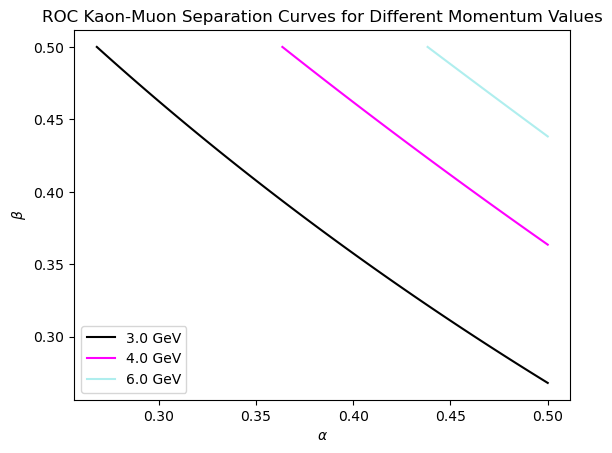

In [13]:
run_Q2()

From the above ROC plot with three different momentum values, we can see that 3 GeV (natural unit) apparently gives the best performance comparing to the 4 GeV and 6 GeV. And 6 GeV is apparently the worst performing one. The increasing momentum shows worsen performance in models because it appears that increasing momentum decreases the separation between the two hypotheses, resulting in more overlapping region, or a "not-so-good" classifier. 

And again, out of the three momentum values here, the 3 GeV ROC curve appears to be the best performing classifier comparing to the other two.

**Problem 3**

total # of events = 43.0 
 # of bins = 50


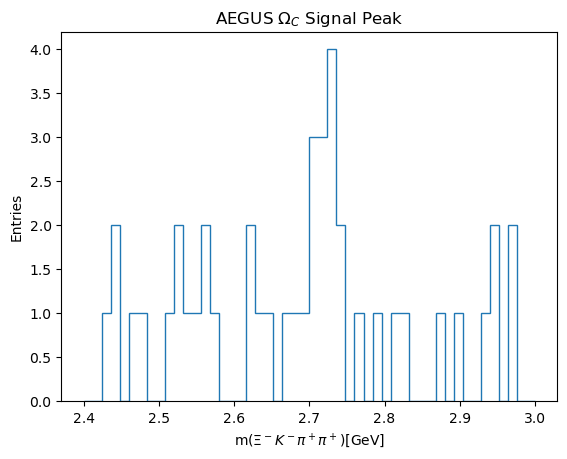

In [14]:
nbins = 50
XMIN = 2.4 # in GeV
XMAX = 3.0 # in GeV
bins = np.linspace(XMIN , XMAX , nbins)
counts = np.array([0, 0, 1, 2, 0, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1, \
0, 1, 1, 1, 3, 3, 4, 2, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, \
0, 1, 2, 0, 2, 0, 0]). astype(float)
tot = 0
for i in counts:
    tot += i
print("total # of events =",tot , "\n # of bins =",len(counts ))
evts, a, b = plt.hist(bins , bins=len(counts),weights=counts, histtype='step', range=(min(bins), max(bins )))
plt.title(r'AEGUS $\Omega_C$ Signal Peak')
plt.xlabel(r'm($\Xi^- K^- \pi^+ \pi^+$)[GeV]')
plt.ylabel('Entries')
plt.show()

**Problem 3.1**

In [15]:
def run_Q3Part1():
    
    #——————————————————————————————————————————————————————————————————————————————————————————————#
    # Assuming all the events are caused by background, calculate the average number of background # 
    # events per bin.                                                                              #
    #——————————————————————————————————————————————————————————————————————————————————————————————#

    print('Assuming all the events are caused by background, the average number of' +
          ' background events per bin is %s' % evts.mean() )
    

    #————————————————————————————————————————————————————————————————————————————————————————#
    # Use method numpy.argmax to find the location of the peak in the mass spectrum (in GeV) #
    #————————————————————————————————————————————————————————————————————————————————————————#

    idx_peak = np.argmax(evts)
    evts_peak = evts[idx_peak]
    E_peak = bins[idx_peak]
    print('The location of the peak in the mass spectrum is located at %.4f GeV with %s counts\n'\
          % (E_peak, int(evts_peak)))
    
    #——————————————————————————————————————————————————————————————————————————————#
    # count the total number of events in a window of +- 2.5 sigma around the peak #
    #——————————————————————————————————————————————————————————————————————————————#

    sigma = 12e-3 # GeV
    window_low = E_peak - 2.5*sigma
    window_high = E_peak + 2.5*sigma
    
    # now calculate the total number of evts in the window
    n_obs_evt = evts[(bins>=window_low) & (bins<=window_high)].sum()
    print('The total number of events in a window of \u00b12.5\u03C3 around the peak is %s (events)\n'\
          % int(n_obs_evt))
    
    # Estimate the number of expected background events within the window
    n_bins_within_window = ((bins>=window_low) & (bins<=window_high)).sum()
    n_expected_bkg_evts = evts.mean() * n_bins_within_window
    print('Within the window of \u00b12.5\u03C3 around the peak, the number of expected' + \
          ' background events is %s\n' % n_expected_bkg_evts)

    # Now calculate the probability for a Poisson distribution with mean of N_bkg to produce N_obs 
    # or more evts. As well as calculating the number of standard deviations it corresponds to
    pois_distribution = poisson(n_expected_bkg_evts)
    p_val = pois_distribution.sf(n_obs_evt)
    n_sigma = calcZ(p_val)
    print('For a Poisson distribution with mean of %s expected events' % n_expected_bkg_evts + \
          ' and there being %s observed events, \nthe significance is %.3f\u03C3' % (n_obs_evt, n_sigma))
    
    

In [16]:
run_Q3Part1()

Assuming all the events are caused by background, the average number of background events per bin is 0.86
The location of the peak in the mass spectrum is located at 2.7306 GeV with 4 counts

The total number of events in a window of ±2.5σ around the peak is 12 (events)

Within the window of ±2.5σ around the peak, the number of expected background events is 4.3

For a Poisson distribution with mean of 4.3 expected events and there being 12.0 observed events, 
the significance is 3.463σ


**Problem 3.2**

In [17]:
def run_Q3Part2():
    # First initialize the fitting class
    fitClass = Fit(counts, XMIN, XMAX, bins)
    fitClass.scan_mass()
    chiSq_diff = np.array(fitClass.chiSq_difference)
    
    # Now plot the delta chiSq with the mass spectrum
    plt.hist(bins, bins=bins.size, weights=chiSq_diff, color='purple')
    plt.xlabel('Mass (GeV)')
    plt.ylabel(r'$\Delta\chi^2$')
    plt.title(r'$\Delta\chi^2$ vs. Fixed Mean Mass Spectrum')
    plt.show()

    # Now find max chiSq difference and then calculate the significance of the deviation
    max_chiSq_diff = chiSq_diff.max()
    p_val = 1 - chi2.cdf(max_chiSq_diff, df=1)
    n_sigma = calcZ(p_val)
    print('There is a probability of %.8f having a \u03c7^2 value greater than %.3f.' % (p_val, max_chiSq_diff))
    print('The significance of the deviation is %.4f\u03C3.' % n_sigma)

E VariableMetricBuilder Initial matrix not pos.def.


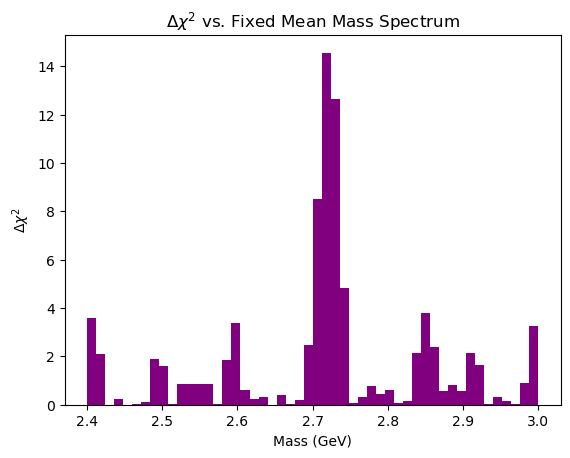

There is a probability of 0.00013534 having a χ^2 value greater than 14.566.
The significance of the deviation is 3.8165σ.


In [18]:
run_Q3Part2()